
<div align="center">
    <img src="./images/logo.png">
</div>

# Définition du projet
## Un défi Kaggle
Ce projet à été trouvé sur Kaggle : https://www.kaggle.com/datasets/terminus7/pokemon-challenge/  
On y retrouve les 3 datasets utilisés pour le défi.
### Description des datasets
+ **pokedex.csv** : liste des 800 Pokémon jusqu'à la 7ieme génération, ainsi que leurs caractéristiques (FOR, DEF, ATK SPE, PV,...)
+ **combats.csv** : liste des combats Pokémon (# index dans le Pokédex) et le vainqeur du combat.
+ **tests.csv** : donnée de test pour le modèle. Identique à combat.csv mais sans le vainqueur.
## Les Pokémon
Pokémon est une franchise médiatique créée par Satoshi Tajiri et Ken Sugimori. Elle a été introduite pour la première fois au Japon en 1996 en tant que jeu vidéo par Nintendo, Game Freak et Creatures. Depuis lors, elle s'est étendue pour inclure une variété de produits, notamment des jeux vidéo, une série télévisée animée, des films, des jouets, des cartes à collectionner et des livres.
### Créatures Pokémon
Pokémon est le terme général pour les 800+ créatures distinctes qui apparaissent dans la franchise. Chaque Pokémon a son propre nom, type (comme feu, eau, plante, etc.), et des capacités spéciales.
### Combats Pokémon
Les dresseurs peuvent faire combattre leurs Pokémon contre d'autres Pokémon sauvages ou ceux d'autres dresseurs. Les combats sont généralement au tour par tour, où chaque Pokémon utilise des attaques ou des mouvements pour infliger des dégâts ou effectuer d'autres actions stratégiques. Chaques dresseurs à le droit à avoir un maximum de 6 Pokémon dans son équipe. Le premier dresseur choisi le Pokemon qui va commencer le combat. C'est en suite à son adverser de choisir l'un de ces Pokemon. Bien évidement celui qui choisi en 2ieme à la possibilité de prendre un Pokemon qui "contre" celui de son adversaire.
## Le modèle
Ce modèle à pour objectif de prédire quel est le Pokémon de son équipe qui à le plus de chance de remporter un combat, selon le Pokémon du desseur adverse. Un Pokémon sera donné en entrée et le modèle prédira quel sera le meilleur pokémon pour le vaincre.

# Préparation des données
## Import des modules python

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pitch_class import Pitch

import xgboost as xgb
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score

from joblib import dump, load

plt.rcParams['figure.facecolor'] = '#282c34'
plt.rcParams['axes.facecolor'] = '#282c34'  # Couleur de fond des axes
plt.rcParams['axes.edgecolor'] = '#999999'  # Couleur des bordures des axes
plt.rcParams['axes.labelcolor'] = '#999999'  # Couleur des étiquettes des axes
plt.rcParams['xtick.color'] = '#999999'  # Couleur des ticks sur l'axe des x
plt.rcParams['ytick.color'] = '#999999'  # Couleur des ticks sur l'axe des y
plt.rcParams['text.color'] = '#999999'

## Importation des datasets
### pokedex.csv
J'ai fait le choix d'utiliser le Pokedex en anglais (celui trouvé dans le projet Kaggle), car celui trouvé en français avait en problème d'encodage et beaucoup d'erreur de chargement. De plus le numéro dans le pokedex entre la version française et anglaise était différent (je ne m'en suis pas rendu compte tout de suite)

In [18]:
pokedex = pd.read_csv('data/pokedex.csv')
pokedex.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [19]:
pokedex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


### combat.csv

In [20]:
combats = pd.read_csv('data/combats.csv')

combats.head(5)

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [21]:
combats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   50000 non-null  int64
 1   Second_pokemon  50000 non-null  int64
 2   Winner          50000 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


### tests.csv

In [22]:
tests = pd.read_csv('data/tests.csv')

tests.head(5)

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115
3,195,618
4,27,656


In [23]:
tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   10000 non-null  int64
 1   Second_pokemon  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


## Commentaires sur les données
+ **pokedex.csv :**
    + **Name :** Il manque le nom d'un pokemon, ce qui ne va pas être difficile à retrouver.
    + **Type 2 :** Il 50% des types 2, ce qui est normal. Tous les pokemon n'ont pas forcément de type 2.
+ **combat.csv :** R.A.S.
+ **test.csv :** R.A.S.


## Nettoyage des données
### Caractères spéciaux dans Name

In [24]:
pokedex['index_sp'] = pokedex['Name'].str.contains(r'[^\x00-\x7F]+')

pokedex[pokedex['index_sp'] == True]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,index_sp
34,35,Nidoran♀,Poison,NaN,55,47,52,40,40,41,1,False,True
37,38,Nidoran♂,Poison,NaN,46,57,40,40,40,50,1,False,True
737,738,Flabébé,Fairy,NaN,44,38,39,61,79,42,6,False,True


Les caractères spéciaux dans les noms sont OK.  
Je vais de toute façon utiliser le numéro du Pokémon (#) dans le modèle.

### Caractères spéciaux dans Type 1 (OK)

In [25]:
pokedex['index_sp'] = pokedex['Type 1'].str.contains(r'[^\x00-\x7F]+')

pokedex[pokedex['index_sp'] == True]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,index_sp


### Caractères spéciaux dans Type 2 (OK)

In [26]:
pokedex['index_sp'] = pokedex['Type 2'].str.contains(r'[^\x00-\x7F]+')

pokedex[pokedex['index_sp'] == True]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,index_sp


In [27]:
# Efface la colonne 'index_sp', qui ne sert plus a rien
pokedex = pokedex.drop(columns='index_sp')

### Le Pokemon manquant

In [28]:
pokedex[pokedex['Name'].isna()]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False


In [29]:
pokedex.loc[60:65]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
60,61,Golduck,Water,NaN,80,82,78,95,80,85,1,False
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False
64,65,Arcanine,Fire,NaN,90,110,80,100,80,95,1,False
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False


**Source:** https://www.pokepedia.fr/Colossinge  
  
Mankey (EN) | Férosinge (FR) < Primeape (EN) | Colossinge (FR) < Growlith (EN) | Caninos (FR)

Le Pokemon recherché est bien **Primeape**. On peut vérifié par rapport à ces caractéristiques : https://www.pokebip.com/pokedex/ecarlate-violet/pokemon/colossinge

In [30]:
pokedex.loc[62, 'Name'] = 'Primeape'

pokedex.loc[61:63]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,Primeape,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False


#### REMARQUES : Indexation des Pokemon
  
Cependant le numéro du pokémon (63) diffère de la documentation sur le net (57). 

En effet, dans la génération 5 ou 6, Pokemon on introduit les formes **"Mega"** et les formes **"X"** et **"Y"**. Les Pokemon sous cette forme portent le même numéro de pokédex que le Pokemon de base.

Exemple : Dracaufeu (FR), Charizard (EN) existe en 4 versions différentes (Dracaufeu, Mega-Dracaufeu X, Mega-Dracaufeu Y et Dracaufeu-Gigamax), mais toutes portent le numéro 6 (https://www.pokemon.com/fr/pokedex/dracaufeu).

Dans le dataset trouvé sur Kaggle, le choix à été fait d'indexer ces formes différement :

In [31]:
pokedex.head(9).tail(3)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
6,7,Charizard,Fire,Flying,78,84,78,109,85,100,1,False
7,8,Mega Charizard X,Fire,Dragon,78,130,111,130,85,100,1,False
8,9,Mega Charizard Y,Fire,Flying,78,104,78,159,115,100,1,False


Dracaufeu est même indexé au numéo 7 du pokedex en raison du fait que Florizzare (FR), Vunasaur (EN) à une Méga frome qui à pris la place du numéro 4, décalant ainsi le reste de la liste.

Sur base de cela on peut déterminer le nombre de pokemon qui ont 'Mega' dans leur nom :

In [32]:
pokemon_mega = pokedex[pokedex['Name'].str.contains('Mega', na=False)]['Name'].count()

pokemon_mega

49

De même, certain Pokemon ont plusieurs formes et ne porte pas forcément "Mega" dans leur nom :

In [33]:
pokedex[pokedex['Name'].str.contains('Pump', na=False)]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
780,781,Pumpkaboo Average Size,Ghost,Grass,49,66,70,44,55,51,6,False
781,782,Pumpkaboo Small Size,Ghost,Grass,44,66,70,44,55,56,6,False
782,783,Pumpkaboo Large Size,Ghost,Grass,54,66,70,44,55,46,6,False
783,784,Pumpkaboo Super Size,Ghost,Grass,59,66,70,44,55,41,6,False


**La différences des 88 Pokemon suppélementaires dans le dataset provint de là. (Je pourrais m'amuser à compter, et il le faudrait, mais j'ai la flem...)**

### Manquants dans Type 2
Comme indiqué précédement, un Pokémon peut ne pas avoir de Type 2. Dans ce fait, je vais considérer ce manque de type comme une information pertinente et ajouter un type : no_type_2, pour ne pas laisser de vide dans le dataset.

In [34]:
nb_miss_t2 = pokedex['Type 2'].isna().sum()

pokedex.loc[pokedex['Type 2'].isna(), 'Type 2'] = 'no_type_2'
nb_not2 = pokedex[pokedex['Type 2'] == 'no_type_2']['Type 2'].count()
        
print(f"Nombre de Type 2 manquant : {nb_miss_t2}")
print(f"Nombre de no_type_2 après remplacement : {nb_not2}")

Nombre de Type 2 manquant : 386
Nombre de no_type_2 après remplacement : 386


# Analyse des données (EDA)

## Pokedex
### Types de données

In [35]:
pokedex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      800 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


### Features Catégoriel
+ Type 1 (nominale)
+ Type 2 (nominale)
+ Generation (ordinale)
+ Legendary (nominale)  
  
*(sachant que Name ne sera pas utilisé dans le model)*

### Features Numérique (Variables Continues)

+ HP
+ Attack
+ Defense
+ Sp. Atk
+ Sp. Def
+ Speed

### Corrélation entre les données continues

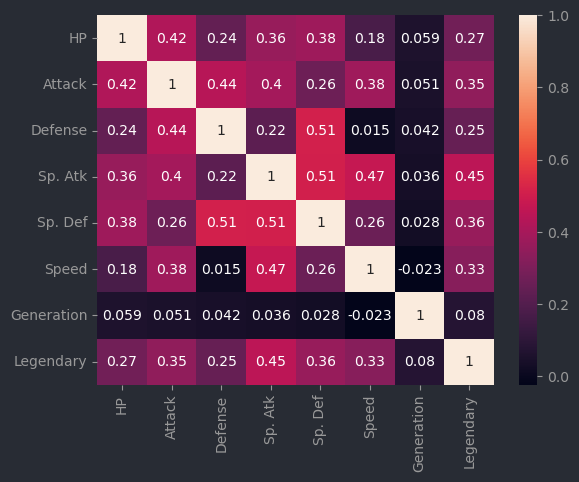

In [36]:
# On retir l'index et le name comme mentionné précédement
corr = pokedex.drop(columns=['#', 'Name', 'Type 1', 'Type 2']).corr()

sns.heatmap(corr, 
        xticklabels=corr.columns, 
        yticklabels=corr.columns, annot=True) 
plt.show() 

On peut être certain que la génération n'a aucune corrélation avec le reste des données (comme je m'en doutais). Cette features n'introduit pas de biais.

De façon générale on voit que les features ont toutes une faibles corrélation entre elle, et c'est normale. On peut se demander pourquoi sp. Atk à une corrélation de 0.51 avec sp. Def. ce qui n'est pas significatif, mais tout de même présent. Tout simplement, quand les concepteurs du jeu on créer leurs Pokémon, ils ont du faire face à un besoin d'équilibrage. Ce qui fait que les pokemon ont tous une certaine puissance moyenne. Si un Pokémon est très fort en attaque, alors il sera plus faible en défense ou en vitesse ou aura moins de HP.  

Le feature Légendaire à également une certaine corrélation (faible) avec les autres features, mais non négligeable par rapport aux autre corrélation. C'est aussi normale, car un pokemon légendaire à certaines de ces features qui sont plus élevées que les pokemon non légendaires (principalement sp. Atk). Le fait qu'un pokemon est légendaire est déjà représenté par ses features. Donc garder la feature Légendaire, c'est introduire un biais dans le model. Je vais donc l'exclure.

## Combats

In [37]:
combats.shape

(50000, 3)

### Représentation de chaque Pokemon en combat

In [38]:
nb_first_position = combats['First_pokemon'].value_counts()
nb_second_position = combats['Second_pokemon'].value_counts()

#### Heatmap des pokemon par position

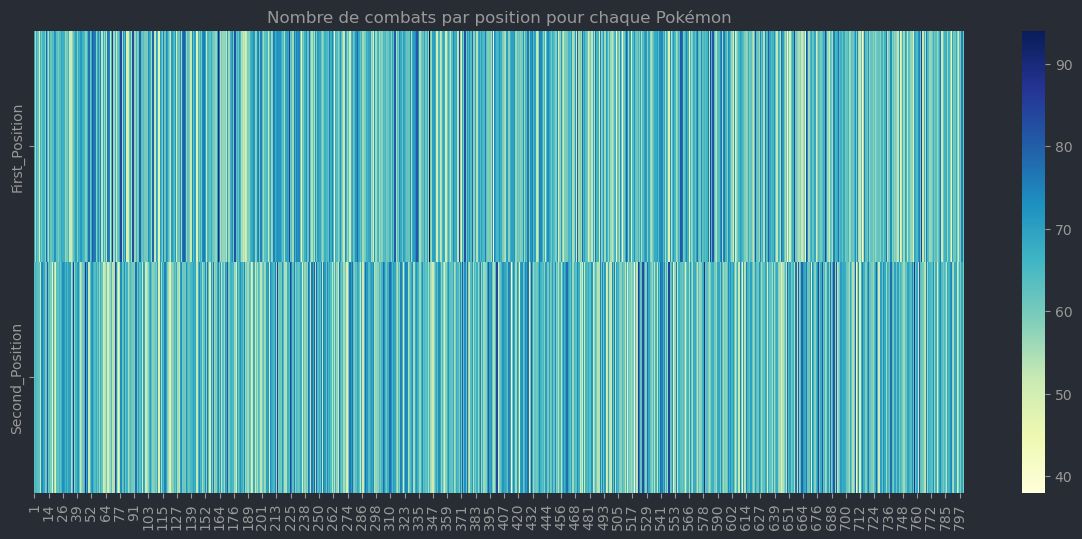

In [39]:
# Préparation des données pour le heatmatp
combined_counts = pd.DataFrame({
    'First_Position': nb_first_position,
    'Second_Position': nb_second_position
}).fillna(0)

plt.figure(figsize=(15, 6))
sns.heatmap(combined_counts.T, cmap='YlGnBu')
plt.title('Nombre de combats par position pour chaque Pokémon')
plt.show()

On voit que de façon générale les pokemons ont tous combatus autour de 40x par position.  
Mais on peut vérifier la distribution des combats par pokemon avec des boites à moustache pour avoir plus de détail.

#### Distribution des combats par Pokemon par position

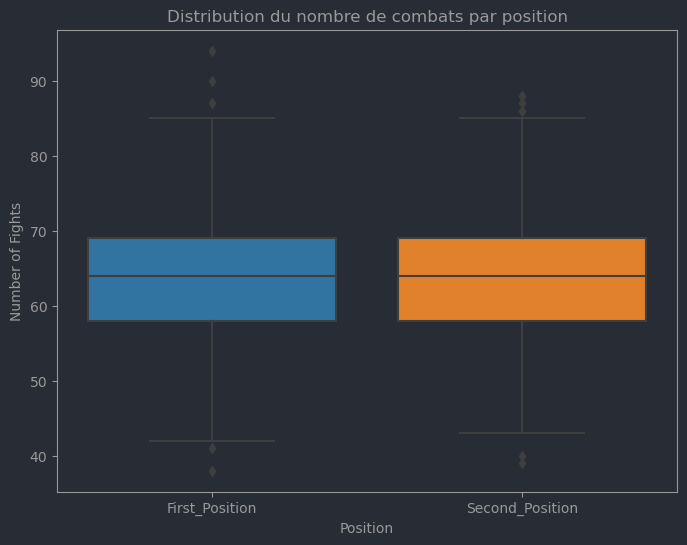

In [40]:
# Préparation des données pour le boxplot
data_melted = combined_counts.melt(value_vars=['First_Position', 'Second_Position'], 
                                   var_name='Position', 
                                   value_name='Number of Fights')

plt.figure(figsize=(8,6))
sns.boxplot(x='Position', y='Number of Fights', data=data_melted)
plt.title('Distribution du nombre de combats par position')
plt.show()

On voit clairement que 50% (Q1:25% à Q3:75%) des pokemons ont fait 60 à 70 combats.  
Les min et les max sont à 40 et 85 combat, ce qui est cohérent avec le heatmap.  

Par contre certaine valeur abérantes (losange) sont assez bassent. Ce qui pourrait poser problème si beaucoup de pokemon sont sous représentés. Pour en avoir le coeur-net on peut calculer combien de pokemon on fait moins de 40 combats en First_position et en Second_position.

In [41]:
nb_first_position[nb_first_position < 40]

First_pokemon
398    38
Name: count, dtype: int64

In [42]:
nb_second_position[nb_second_position < 40]

Second_pokemon
519    39
Name: count, dtype: int64

  
Après vérification, aucun pokemon n'a combattu trop peut de fois.  
  
**On peut donc dire que tous les pokemon, sont parfaitement représentés dans le dataset de combat**

### Cas des Pokémon s'affrontant eux-mêmes
Dans un combat Pokémon, on peut très bien faire combattre le même Pokémon. Pour déterminer quel Pokémon attaquera en 1er, on se base sur sa feature 'Speed' (le plus élevé commence). Quand 2 mêmes Pokémon se battent, leur 'Speed' est la même. En cas d'égalité, le Pokémon qui commence sera déterminé au hasard en lançant une pièce : P (A|B) : 50%. Dans ce cas, c'est TOUJOURS le pokémon qui commence qui gagnera le combat (sauf si son dresseur -- le joueur -- joue très très très mal)

In [43]:
combats[combats['First_pokemon'] == combats['Second_pokemon']].count()

First_pokemon     0
Second_pokemon    0
Winner            0
dtype: int64

Dans le dataset combats, on voit que ce cas de 2 mêmes pokémons qui se combattent n'est pas représenté. Ce qui peut indroduire dans le modèle des erreurs de prédiction (et ça va le faire, j'ai testé). Pour cela, je vais introduire dans le dataset combats, un ensemble de combat opposant chaque pokémon à lui-même 2x. 1x où c'est le pokémon en 1ere position qui gagnera et 1x où c'est le 2ieme (pour représenter la probabilité 50/50 de gagner).

#### Ajout des combats contre eux-mêmes

##### Création du label (y)
Le but du model est de prédire si le Pokémon en 2ieme position gagnera contre le Pokémon en 1ere position.  
Donc à chaque fois que le 2ieme Pokémon sera déclaré gagné dans les données d'entrainement, on indiquera 1 si non 0.

In [44]:
combats['Winner'] = combats['Winner'] == combats['Second_pokemon'].astype(int)
combats['Winner'].unique()

array([ True, False])

In [45]:
nb_pokemon = pokedex['#'].count()
nb_pokemon

800

In [46]:
# Créer le DataFrame pour les défaites (où le premier Pokémon perd)
defeats = pd.DataFrame({'First_pokemon': range(1, nb_pokemon + 1), 'Second_pokemon': range(1, nb_pokemon + 1), 'Winner': [0] * nb_pokemon})
wins = pd.DataFrame({'First_pokemon': range(1, nb_pokemon + 1), 'Second_pokemon': range(1, nb_pokemon + 1), 'Winner': [1] * nb_pokemon})

combats = pd.concat([combats, defeats, wins]).reset_index(drop=True)


combats[(combats['First_pokemon'] == 31) & (combats['Second_pokemon'] == 31)]

,First_pokemon,Second_pokemon,Winner
50030,31,31,0
50830,31,31,1


**ATTENTION :** après une concaténation avec pandas, les dataframes ne sont pas "collé" à la suite, mais réindexé (trié). Ici la colonne Winner, 0 est contenu dans toutes les 1ere lignes, alors que 1 est dans les dernières.

**Il faudra stratifié les données d'entrainement pour être certain que les 2 catégories seront bien représentées**

# Création du model de Machine Learning

## Préparation des données pour le Machine Learning

### Création des données d'entrainement et de test

In [31]:
# Retire les features à exclure
pokedex_features = pokedex.drop(columns=['Name', 'Generation', 'Legendary'])

# Remplace l'index du pokemon par ses features
train_df = combats.merge(pokedex_features, left_on='First_pokemon', right_on='#', suffixes=('', '_1'))
train_df = train_df.merge(pokedex_features, left_on='Second_pokemon', right_on='#', suffixes=('_1', '_2'))

train_df.columns

Index(['First_pokemon', 'Second_pokemon', 'Winner', '#_1', 'Type 1_1',
       'Type 2_1', 'HP_1', 'Attack_1', 'Defense_1', 'Sp. Atk_1', 'Sp. Def_1',
       'Speed_1', '#_2', 'Type 1_2', 'Type 2_2', 'HP_2', 'Attack_2',
       'Defense_2', 'Sp. Atk_2', 'Sp. Def_2', 'Speed_2'],
      dtype='object')

In [32]:
# Supprime les colonnes innutiles
train_df = train_df.drop(columns=[
    'First_pokemon', 
    'Second_pokemon', 
    '#_1', 
    '#_2'
])

train_df.head(5)

,Winner,Type 1_1,Type 2_1,HP_1,Attack_1,Defense_1,Sp. Atk_1,Sp. Def_1,Speed_1,Type 1_2,Type 2_2,HP_2,Attack_2,Defense_2,Sp. Atk_2,Sp. Def_2,Speed_2
0,1,Rock,Ground,50,64,50,45,50,41,Grass,Dark,70,70,40,60,40,60
1,1,Fighting,no_type_2,70,80,50,35,35,35,Grass,Dark,70,70,40,60,40,60
2,1,Water,Ground,110,78,73,76,71,60,Grass,Dark,70,70,40,60,40,60
3,0,Electric,Flying,50,65,107,105,107,86,Grass,Dark,70,70,40,60,40,60
4,0,Normal,no_type_2,73,115,60,60,60,90,Grass,Dark,70,70,40,60,40,60


In [33]:
# Prépare les données pour l'entrainement du model
pitcher = Pitch()

x_train, y_train, x_test, y_test = pitcher.pitch_data(
    train_df, 
    y_name = 'Winner',
    one_hot = ['Type 1_1','Type 1_2', 'Type 2_1', 'Type 2_2'],
    seed = 1
)

print(f"x_train: {x_train.shape}  y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}  y_test: {y_test.shape}")

x_train[0]

x_train: (41280, 86)  y_train: (41280,)
x_test: (10320, 86)  y_test: (10320,)


array([ 60., 115., 105.,  65.,  70.,  80.,  90.,  93.,  55.,  70.,  55.,
        55.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
         0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

## Modèle : XGBoost Classifier

### Création en Entrainement

In [34]:
epoch = 100

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=epoch, seed=1)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [35]:
acc = xgb_model.score(x_test, y_test)

y_prob = xgb_model.predict_proba(x_test)[:, 1]
loss = log_loss(y_test, y_prob)

print(f"Accuracy: {acc:.4f}    Loss: {loss:.4f}")

Accuracy: 0.9524    Loss: 0.1183


In [36]:
test_val = 1
prediction = xgb_model.predict_proba(x_test[test_val].reshape(1, -1))

print(f"Label: {y_test[test_val]}   Prediction: {prediction}")

Label: 1   Prediction: [[0.01165372 0.9883463 ]]


### Performance du model

In [37]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error']  # logloss pour le loss, error pour 1 - accuracy
}

evals = [(dtrain, 'train'), (dtest, 'test')]

evals_result = {}
bst = xgb.train(params, dtrain, epoch, evals, evals_result=evals_result, verbose_eval=False)

/Users/kaham/anaconda3/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


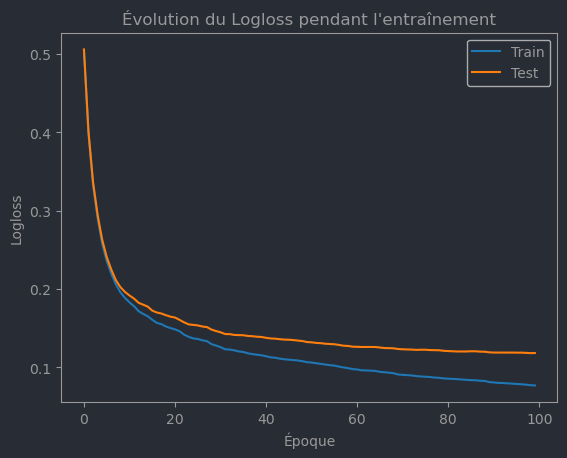

In [38]:
# Pour le loss
plt.plot(evals_result['train']['logloss'], label='Train')
plt.plot(evals_result['test']['logloss'], label='Test')
plt.xlabel('Époque')
plt.ylabel('Logloss')
plt.title('Évolution du Logloss pendant l\'entraînement')
plt.legend()
plt.show()

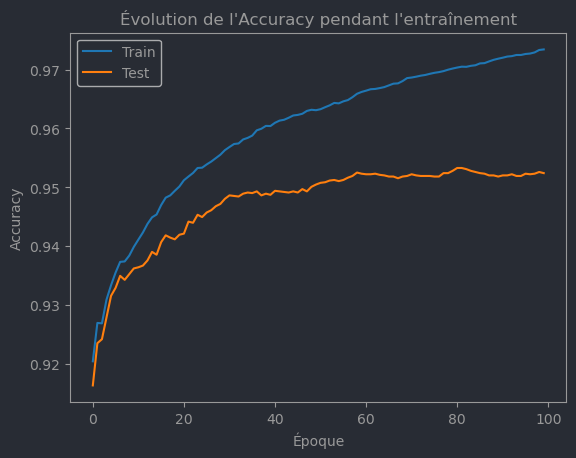

In [39]:
# Pour l'accuracy
plt.plot([1 - err for err in evals_result['train']['error']], label='Train')
plt.plot([1 - err for err in evals_result['test']['error']], label='Test')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.title('Évolution de l\'Accuracy pendant l\'entraînement')
plt.legend()
plt.show()

### Validation croisée (Overfitting)

In [40]:
X = np.concatenate((x_train, x_test), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

scores = cross_val_score(xgb_model, X, Y, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.95 (+/- 0.00)


Une précision de 0.95 sur l'entrainement et 0.95 sur la validation croisée avec une variance de 0.00 ne signal pas d'Overfitting. C'est Extrêment bien comme score !
Voir exceptionnel ! 

Risque que les données ne soient pas représentative des cas réel.
(A vérifier avec un test sur d'autres données)

## Sauvegarde du model

### Sauvegarde

In [41]:
dump(xgb_model, "pokemon_winner.mod")

['pokemon_winner.mod']

### Chargement et test

In [42]:
loaded_model = load("pokemon_winner.mod")

test_val = 2
prediction = loaded_model.predict_proba(x_test[test_val].reshape(1, -1))

print(f"Label: {y_test[test_val]}   Prediction: {prediction}")

Label: 1   Prediction: [[0.01165372 0.9883463 ]]


### Sauvegarde des données du pokedex
*(Les données ont étés nettoyées donc autant utiliser celles-là pour le client)*

In [43]:
pokedex.head(3)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False


In [44]:
pokedex.to_csv("pokedex.csv", index=False)

## Sauvegarde de l'encoder

In [45]:
pitcher.save('encoder_pokemon.ec')

# API

## API à mettre dans un fichier 'pokerate.py'

In [46]:
# *************************************************************************************************************
# How to using this API
# *************************************************************************************************************
# Comments 1 : You need to have those file in model directory
# -- model/pokarate.py             (is this API file)
# -- model/pokedex.csv             (is the pokedex)
# -- model/pokemon_winner.mod      (is the IA model)
# -- model/encoder_pokemon.ec      (is the encoder the IA model need to work)
# -- model/pitch_data.py           (is a class the API need to work)
# *************************************************************************************************************
# Comments 2 : Actually the IA have difficulty to predict a 50/50% winner when the same pokemon are fighting
# The best way to
# *************************************************************************************************************
# import pokarate.py
#
# pokerate_model = Pokerate()
#
# poke_1 = 1
# poke_2 = 2
# prediction = pokerate_model.predict_battle(poke_1, poke_2) # Use Pokemon index (from pokedex)
#
# print(f"Pokemon 1 winning rate : {prediction[0, 0]:.2f}%")
# print(f"Pokemon 2 winning rate : {prediction[0, 1]:.2f}%")
#
# if prediction[0, 0] > prediction[0, 1]:
#     print(f"The winner is : {pokarate_model.get_poke_name(poke_1)}")
# else:
#     print(f"The winner is : {pokarate_model.get_poke_name(poke_2)}")
# *************************************************************************************************************

import pandas as pd
import numpy as np
import joblib
from model.pitch_class import Pitch

class Pokerate():
    pokedex = pd.read_csv('model/pokedex.csv')
    _pokedex_features = pokedex.drop(columns=['Name', 'Generation', 'Legendary'])
    _model = joblib.load('model/pokemon_winner.mod')

    def __init__(self):
        self.pitcher = Pitch()
        self.pitcher.load('model/encoder_pokemon.ec')

    def _prepare_data(self, poke_1, poke_2):
        combats = pd.DataFrame({'First_pokemon': [poke_1], 'Second_pokemon' : [poke_2]})

        train_df = combats.merge(self._pokedex_features, left_on='First_pokemon', right_on='#', suffixes=('', '_1'))
        train_df = train_df.merge(self._pokedex_features, left_on='Second_pokemon', right_on='#', suffixes=('_1', '_2'))

        train_df = train_df.drop(columns=['First_pokemon', 'Second_pokemon', '#_1', '#_2'])

        encoded_data = self.pitcher.encode(train_df)

        prepared_data = self.pitcher.pitch_data(encoded_data)

        return prepared_data

    def predict_battle(self, pokemon_index_1:int, pokemon_index_2:int) -> np.array:
        battle_data = self._prepare_data(pokemon_index_1, pokemon_index_2)
        prediction = self._model.predict_proba(battle_data)

        return prediction

    def get_poke_name(self, index_poke:int) -> pd.DataFrame:
        return self.pokedex[self.pokedex['#'] == index_poke]['Name']

    def get_poke_stats(self, index_poke) -> pd.DataFrame:
        return self.pokedex[self.pokedex['#'] == index_poke]

In [51]:
pokerate_model = Pokerate()

poke_1 = 1
poke_2 = 2
prediction = pokerate_model.predict_battle(poke_1, poke_2) # Use Pokemon index (from pokedex)

print(f"Pokemon 1 winning rate : {prediction[0, 0]:.2f}%")
print(f"Pokemon 2 winning rate : {prediction[0, 1]:.2f}%")

if prediction[0, 0] > prediction[0, 1]:
    print(f"The winner is : {pokerate_model.pokedex[pokerate_model.pokedex['#'] == poke_1]['Name'].item()}")
else:
    print(f"The winner is : {pokerate_model.pokedex[pokerate_model.pokedex['#'] == poke_2]['Name'].item()}")

NameError: name 'Pokerate' is not defined

In [52]:
pokedex[(pokedex['#'] == poke_1) | (pokedex['#'] == poke_2)]

NameError: name 'poke_1' is not defined

In [73]:
combats[(combats['First_pokemon'] == 547) & (combats['Second_pokemon'] == 123)]

,First_pokemon,Second_pokemon,Winner
